In [1]:
import os
import numpy as np
import time
import tensorflow as tf
import numpy as np
from tensorflow import keras
import collections
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

Duplicate key in file '/Users/gurdit.chahal/.matplotlib/matplotlibrc' line #2.


In [2]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


In [33]:
#parameters to limit data set for sake of example and pad as needed
vocab_size = 10000
 
pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2
 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size, start_char=start_id,
                                                                        oov_char=oov_id, index_from=index_offset)
word2idx = tf.keras.datasets.imdb.get_word_index()
 
idx2word = {v + index_offset: k for k, v in word2idx.items()}
 
#padding ids for start , end of sentence as well as out of vocab
idx2word[pad_id] = '<PAD>'
idx2word[start_id] = '<START>'
idx2word[oov_id] = '<OOV>'
 


In [34]:
# a look at some of the index-word mappings
{k: idx2word[k] for k in range(10)}

{0: '<PAD>',
 1: '<START>',
 2: '<OOV>',
 3: 'the',
 4: 'and',
 5: 'a',
 6: 'of',
 7: 'to',
 8: 'is',
 9: 'br'}

In [35]:
# we see every sentence starts with <START>, and we will pad so that it ends with sequence of <PAD> until it hits the desired length
x_train

array([list([1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]),
       list([1, 193, 1152, 193, 8254, 77, 227, 

In [32]:
#binary labels
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [4]:
#parameters for our classification model and sequence length
max_len = 200
embedding_units=256
rnn_units = 256
attn_units=128

In [37]:
#pad and truncate sentences as needed
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                 maxlen=max_len,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len,
                                truncating='post',
                                padding='post',
                                value=pad_id)

In [38]:
#now see <PAD> at trailing end
x_train

array([[   1,   13,   21, ...,  225,   64,   15],
       [   1,  193, 1152, ...,    0,    0,    0],
       [   1,   13,   46, ...,    0,    0,    0],
       ...,
       [   1,   10,    5, ...,    0,    0,    0],
       [   1, 1445, 7078, ...,    0,    0,    0],
       [   1,   16,    5, ...,    0,    0,    0]], dtype=int32)

Implementation of Bahdanau Attention with scoring function:  

$\textbf{score}(s_{t},h_{i})=v_{a}^T tanh(W_{a}[s_{t};h_{i}])$

where both $v_{a}$ and $W_{a}$ are weight matrices to be learned in the alignment model and $h_{i}$ denotes the hidden state.

In [6]:
#our attention layer, uses Bahdanau Attention from 2015 paper that's essentially weighted sum, also known as "additive attention"
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self._name="Attention"
 
    def call(self, features, hidden):
    # hidden state shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
    # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

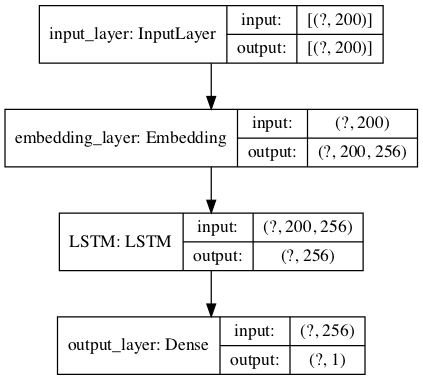

In [13]:
#Simple LSTM Classifier
sequence_input = layers.Input(shape=(max_len,),name="input_layer", dtype='int32')
embeddings = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_units, input_length=max_len,name="embedding_layer")(sequence_input)
rnn_output=tf.keras.layers.LSTM(rnn_units,name='LSTM')(embeddings)
output = keras.layers.Dense(1, activation='sigmoid',name='output_layer')(rnn_output)
model = keras.Model(inputs=sequence_input, outputs=output)
 
# summarize layers
#can use print(model.summary()) if you don't have pydot + graphviz installed
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#adding callback to allow for early stopping, patience =3 means wait up to 3 epochs of no change before terminating
#min_delta is minimum tolerance in improvement of model required to be considered a non-negligible amount 
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=3,
                                                        verbose=0, mode='auto')


In [15]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=200,
                    validation_split=.3, verbose=1, callbacks=[early_stopping_callback])


Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 88s 5ms/sample - loss: 0.6905 - accuracy: 0.5172 - val_loss: 0.6889 - val_accuracy: 0.5341
Epoch 2/10
17500/17500 [==============================] - 79s 5ms/sample - loss: 0.6557 - accuracy: 0.6138 - val_loss: 0.6657 - val_accuracy: 0.6003
Epoch 3/10
17500/17500 [==============================] - 75s 4ms/sample - loss: 0.6277 - accuracy: 0.6618 - val_loss: 0.8134 - val_accuracy: 0.5569
Epoch 4/10
17500/17500 [==============================] - 78s 4ms/sample - loss: 0.5968 - accuracy: 0.6800 - val_loss: 0.6423 - val_accuracy: 0.6479
Epoch 5/10
17500/17500 [==============================] - 83s 5ms/sample - loss: 0.5528 - accuracy: 0.7058 - val_loss: 0.5629 - val_accuracy: 0.7700
Epoch 6/10
17500/17500 [==============================] - 83s 5ms/sample - loss: 0.4522 - accuracy: 0.8087 - val_loss: 0.7200 - val_accuracy: 0.6043
Epoch 7/10
17500/17500 [==============================] -

In [16]:
result = model.evaluate(x_test, y_test)
print(result)

25000/25000 [==============================] - 61s 2ms/sample - loss: 0.6988 - accuracy: 0.6448
[0.6987517935562134, 0.64476]


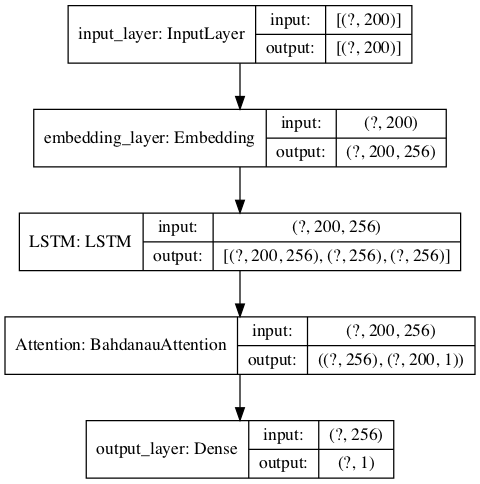

In [17]:
#LSTM Classifier with Attention
sequence_input = layers.Input(shape=(max_len,),name="input_layer", dtype='int32')
embeddings = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_units, input_length=max_len,name="embedding_layer")(sequence_input)
lstm_output,hidden_h, hidden_c=tf.keras.layers.LSTM(rnn_units,name='LSTM',return_sequences=True,
                                      return_state=True)(embeddings)
context_vector, attention_weights = BahdanauAttention(attn_units)(lstm_output, hidden_h)
output = keras.layers.Dense(1, activation='sigmoid',name='output_layer')(context_vector)
attn_model = keras.Model(inputs=sequence_input, outputs=output)
 
# summarize layers
keras.utils.plot_model(attn_model, show_shapes=True, dpi=90)

In [18]:
attn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=3,
                                                        verbose=0, mode='auto')


In [19]:
history = attn_model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=200,
                    validation_split=.3, verbose=1, callbacks=[early_stopping_callback])


Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 89s 5ms/sample - loss: 0.5456 - accuracy: 0.7147 - val_loss: 0.3599 - val_accuracy: 0.8479
Epoch 2/10
17500/17500 [==============================] - 98s 6ms/sample - loss: 0.2908 - accuracy: 0.8857 - val_loss: 0.3275 - val_accuracy: 0.8629
Epoch 3/10
17500/17500 [==============================] - 108s 6ms/sample - loss: 0.2102 - accuracy: 0.9254 - val_loss: 0.3596 - val_accuracy: 0.8515
Epoch 4/10
17500/17500 [==============================] - 108s 6ms/sample - loss: 0.1631 - accuracy: 0.9451 - val_loss: 0.4266 - val_accuracy: 0.8512
Epoch 5/10
17500/17500 [==============================] - 107s 6ms/sample - loss: 0.1339 - accuracy: 0.9523 - val_loss: 0.4167 - val_accuracy: 0.8492


In [20]:
result = attn_model.evaluate(x_test, y_test)
print(result)

25000/25000 [==============================] - 68s 3ms/sample - loss: 0.4828 - accuracy: 0.8271
[0.4827897659111023, 0.82712]
